# 今日任务Ⅱ：维数简约可视化

3. 给定的 17flowers 图像数据集，探讨 LDA 的降为效果

In [46]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.model_selection import train_test_split
from sklearn import datasets
from utils.os import get_root_path

# 可视化超参数
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'olive', 'cyan', 'navy', 'lime', 'tan', 'indigo', 'gold', 'violet']

from torchvision import transforms
from PIL import Image

def crop_center_square(image_path, size_resized):
    """
    剪裁图像为方形
    """
    image = Image.open(image_path)
    width, height = image.size
    min_dim = min(width, height)
    
    crop_transform = transforms.Compose([
        transforms.CenterCrop(min_dim),
        transforms.Resize(size_resized),
    ])
    
    crop_image = crop_transform(image)
    return crop_image

def resize_image(image, size_resized):
    """
    调整图像大小
    """
    resize_transform = transforms.Compose([
        transforms.Resize(size_resized),
    ])
    image = resize_transform(image)
    return image

def check_overlap(box1, box2):
    """
    判断两个矩形框是否有重叠
    """
    # box: (x, y, w, h)
    return not (box1[0] + box1[2] < box2[0] or box1[0] > box2[0] + box2[2] or box1[1] + box1[3] < box2[1] or box1[1] > box2[1] + box2[3])

def plot_images(X, pos, ax):
    """
    在每个点旁边显示数字图像，如果有碰撞则不显示
    Args: 
        X: 图像数据集
        pos: 图像位置（在经过降维后的坐标）
        ax: 绘图对象 axis(axes)
    """
    boxes = []
    for idx in range(len(pos)):
        img = X[idx]
        imagebox = OffsetImage(img, zoom=0.25)
        ab = AnnotationBbox(imagebox, (pos[idx, 0], pos[idx, 1] + 25), frameon=True, pad=0.05)
        ax.add_artist(ab)
        
        bbox = ab.get_window_extent(ax.figure.canvas.get_renderer())
        
        # 碰撞检测
        any_collision = False
        for box in boxes:
            if check_overlap(bbox.bounds, box.bounds):
                any_collision = True
                break
                
        if not any_collision:
            boxes.append(bbox)
        else:
            ab.remove()

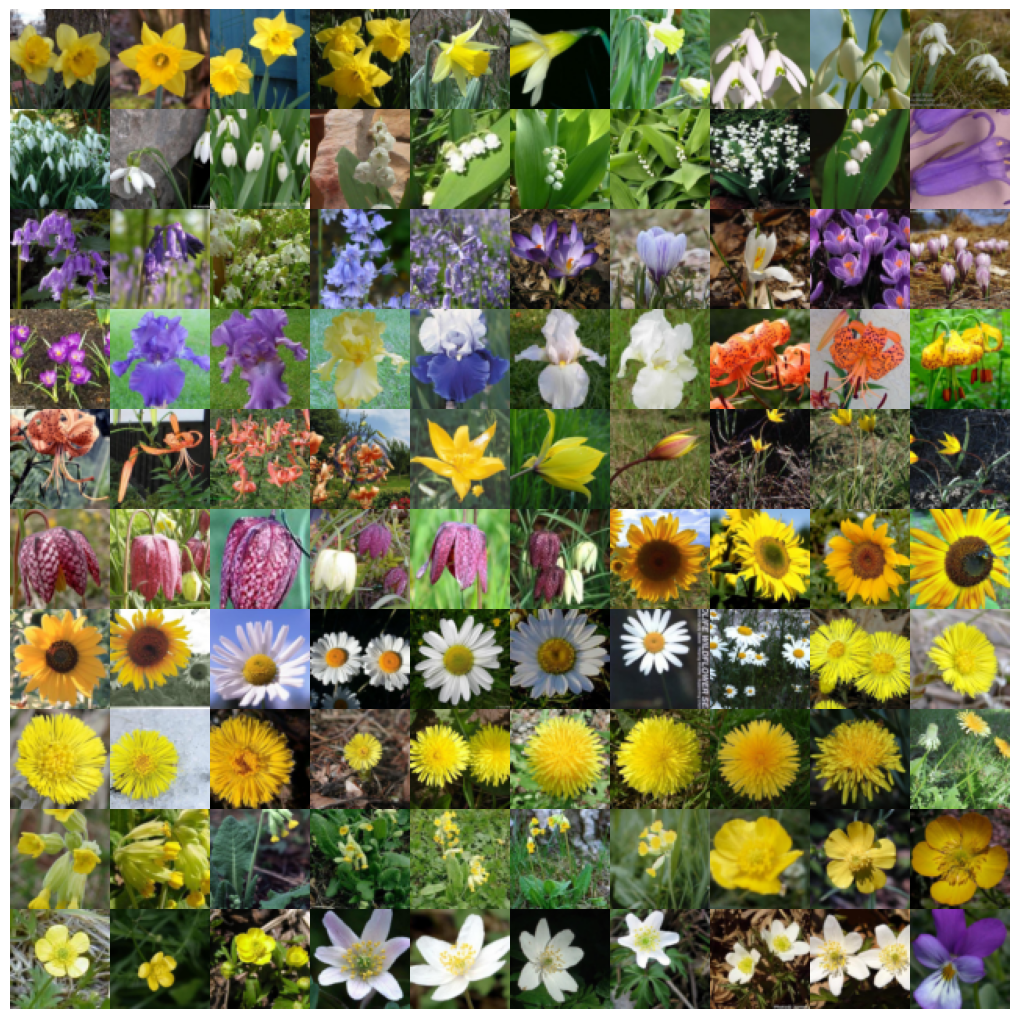

In [44]:
# 文件结构：
# datas/Ch5-LDA_dataset_17flowers/17flowers/
# ├── image_001.jpg
# ├── image_002.jpg
# ├── ...
# └── image_1360.jpg # 共 1360 张图片
# 读取并可视化本地路径 datas/Ch5-LDA_dataset_17flowers/17flowers 下所有图片的数据集
    
# 读取本地路径下的所有图片，17 个类，每个类 80 张图片，共 1360 张图片
image_root = f'{get_root_path()}/datas/Ch5-LDA_dataset_17flowers/17flowers/'
image_name_list = os.listdir(image_root)
n_class = 17
n_samples = 80
n_display = 10 * 10
n_rows = n_cols = int(math.sqrt(n_display))

# 获取其中一个图像的大小作为统一的显示大小
fig_size = (10, 10)

# 显示图片的密集排布形式
fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1)
image_name_display_list = image_name_list[::13][:n_display]
for i, image_name in enumerate(image_name_display_list):
    image_path = os.path.join(image_root, image_name)
    image = crop_center_square(image_path, size_resized=64)
    
    axes[i // n_cols][i % n_cols].imshow(image)
    axes[i // n_cols][i % n_cols].axis('off')

plt.show()


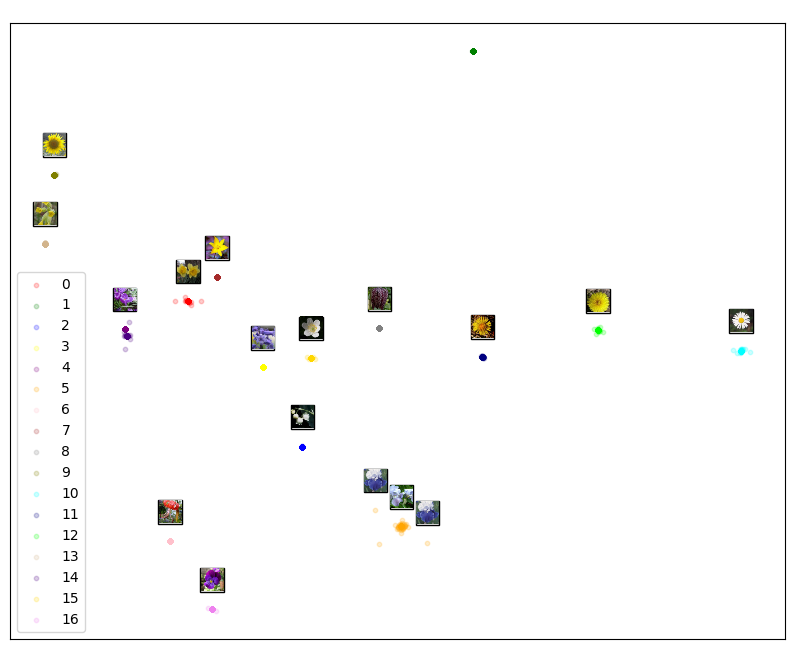

In [48]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# 构建数据集
display_images = []
X_train = []
y_train = []
for i, image_name in enumerate(image_name_list):
    image_path = os.path.join(image_root, image_name)
    image = crop_center_square(image_path, size_resized=64)
    
    display_images.append(image)
    X_train.append(np.array(image).flatten())
    y_train.append(i // n_samples)
    
# 转换为 numpy 数组，使得 y_train[y_train == i] 为 np.ndarray 数据
X_train = np.array(X_train)
y_train = np.array(y_train)
    
# 创建 LDA 模型并进行降维
lda = LDA(n_components=2)
X_r2 = lda.fit_transform(X_train, y_train)

# 绘制降维后的数据
fig, ax = plt.subplots(figsize=(10, 8))
# 绘制每朵花的散点图
for i in range(len(colors)):
    plt.scatter(X_r2[y_train == i, 0], X_r2[y_train == i, 1], s=10, alpha=0.2, color=colors[i], label=str(i))
# 绘制图像
plot_images(display_images, X_r2, ax)

# 不显示刻度，仅显示边框
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.show()
